<a href="https://colab.research.google.com/github/stevegbrooks/big-portfolio-learner/blob/time-series/notebooks/step3b_global_tsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Final Project

## Big Portfolio Learner: Time Series Analysis

### Team members: Steven Brooks & Chenlia Xu

In [89]:
import random
import numpy as np 
import json
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os

In [2]:
%%capture
## If boto3 not already installed uncomment the following:
!pip3 install boto3

In [3]:
import boto3
from botocore import UNSIGNED

from botocore.config import Config

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3.Bucket('cis545project').download_file('data/stock_data.zip', 'stock_data.zip')
s3.Bucket('cis545project').download_file('data/technical_data.zip', 'technical_data.zip')

In [4]:
%%capture

if not os.path.exists("stock_data"):
  os.makedirs("stock_data")
!unzip /content/stock_data.zip -d /content/stock_data
!rm -f stock_data/.gitempty

if not os.path.exists("technical_data"):
  os.makedirs("technical_data")
!unzip /content/technical_data.zip -d /content/technical_data
!rm -f technical_data/.gitempty

# Setup for Spark

In [5]:
%%capture

!wget -nc https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz

!apt install libkrb5-dev
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user

!apt update
!apt install gcc python-dev libkrb5-dev

In [6]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

spark = SparkSession.builder.getOrCreate()

%load_ext sparkmagic.magics

os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Setup for Darts (Time Series Modeling)

In [7]:
%%capture
!pip install 'u8darts[all]'

In [68]:
import torch

from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller

torch.manual_seed(1); np.random.seed(1)  # for reproducibility

# Load the stock data

In [9]:
stock_data_sdf = spark.read.load(
    'stock_data/*.csv', 
    format = 'csv', 
    header = 'true', 
    inferSchema = 'true', 
    sep = ','
)

## Clean

In [10]:
from pyspark.sql.functions import log, to_timestamp
from pyspark.sql.functions import year, month, date_format


stock_data_sdf = stock_data_sdf.withColumn("timestamp_as_dt", to_timestamp(stock_data_sdf.timestamp, 'yyyy-MM-dd'))
stock_data_sdf = stock_data_sdf.withColumn("year", year('timestamp_as_dt'))
stock_data_sdf = stock_data_sdf.withColumn("year_mon", date_format('timestamp_as_dt', 'yyyy-MM'))
stock_data_sdf = stock_data_sdf.withColumn("adjusted_close_log", log("adjusted_close"))
stock_data_sdf = stock_data_sdf.filter("year >= 2002 AND year <= 2019")

count_by_symbol_year_sdf = stock_data_sdf.groupBy(["symbol", "year"]).count()
count_years_by_symbol_sdf = count_by_symbol_year_sdf.groupBy(["symbol"]).count()

### Just grab stocks that have data in each of the 18 years from 2002 to 2019
### AND remove the three outliers
stocks_with_all_analysis_yrs_sdf = count_years_by_symbol_sdf.filter("count == 18") #18 years of data from 2002 and 2019
stocks_to_remove = ['DCTH', 'BRK-A', 'AIKI']
stocks_with_all_analysis_yrs_sdf = stocks_with_all_analysis_yrs_sdf.filter(stocks_with_all_analysis_yrs_sdf.symbol.isin(stocks_to_remove) == False)

stock_data_sdf.createOrReplaceTempView("stock_data")
stocks_with_all_analysis_yrs_sdf.createOrReplaceTempView("stocks_with_all_analysis_yrs")

stock_data_cleaned_sdf = spark.sql(
    """
    SELECT *
    FROM stock_data
    WHERE symbol IN (SELECT symbol FROM stocks_with_all_analysis_yrs)
    """
)

## Transform the LAMR stock into a Darts TimeSeries and build a Model


In [11]:
stock_data_series = stock_data_cleaned_sdf.limit(10000).toPandas()

stock_time_series = stock_data_series.set_index("timestamp_as_dt")
stock_data_TS = TimeSeries.from_series(stock_time_series[stock_time_series.symbol == "LAMR"]["adjusted_close_log"].resample("1D").last())

filler = MissingValuesFiller()
stock_data_TS_filled = filler.transform(stock_data_TS)

In [29]:
train, val = stock_data_TS_filled[:-500], stock_data_TS_filled[-500:]

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [31]:
model = NBEATSModel(
    input_chunk_length=2000, 
    output_chunk_length=500, 
    n_epochs=100, 
    random_state=15
)

In [32]:
model.fit(train, verbose=True)

[2021-12-21 09:08:46,446] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3574 samples.
[2021-12-21 09:08:46,446] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3574 samples.
[2021-12-21 09:08:46,628] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-21 09:08:46,628] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  1%|          | 1/100 [00:07<12:18,  7.46s/it]

 11%|█         | 11/100 [01:23<11:22,  7.66s/it]

 21%|██        | 21/100 [02:36<09:41,  7.36s/it]

 31%|███       | 31/100 [03:54<09:19,  8.10s/it]

 41%|████      | 41/100 [05:18<09:02,  9.20s/it]

 51%|█████     | 51/100 [06:41<06:36,  8.09s/it]

 61%|██████    | 61/100 [08:03<05:19,  8.20s/it]

 71%|███████   | 71/100 [09:23<03:52,  8.01s/it]

 81%|████████  | 81/100 [10:45<02:26,  7.71s/it]

 91%|█████████ | 91/100 [11:59<01:06,  7.41s/it]

100%|██████████| 100/100 [13:05<00:00,  7.86s/it]


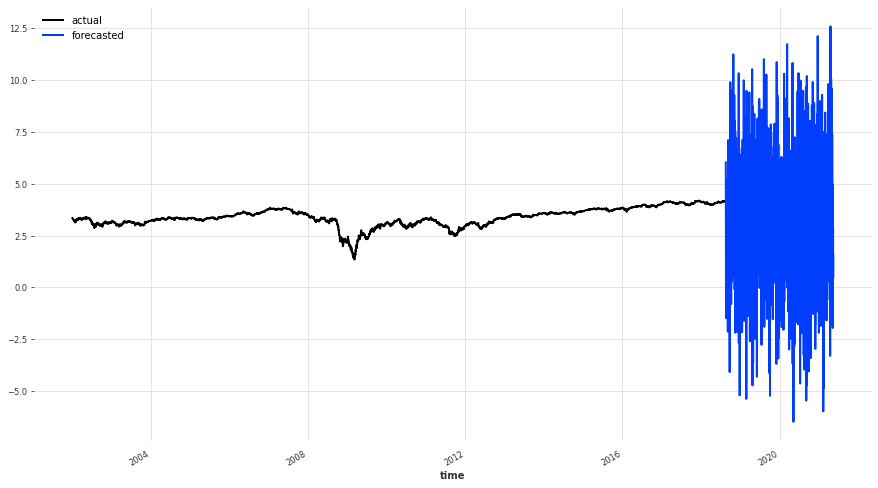

In [33]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8

pred = model.predict(n = 1000, series = train)
stock_data_TS_filled.plot(label = "actual")
pred.plot(label = "forecasted") # validation data set
plt.legend()

# Improve by adding technical indicators

In [34]:
from pyspark.sql.types import StructField, DoubleType, StructType, StringType

structs=[
  StructField('symbol', StringType(), True),
  StructField('timestamp', StringType(), True),
  StructField('EMA', DoubleType(), True),
  StructField('MACD', DoubleType(), True),
  StructField('SlowD', DoubleType(), True),
  StructField('RSI', DoubleType(), True),
  StructField('Real_Middle_Band', DoubleType(), True)
]

schema = StructType(fields = structs)

technical_data_sdf = spark.read.load(
    'technical_data/*.csv', 
    format = 'csv', 
    header = 'true', 
    schema = schema, 
    sep = ','
)

In [35]:
technical_data_sdf = technical_data_sdf.withColumn("timestamp_as_dt", to_timestamp(technical_data_sdf.timestamp, 'yyyy-MM-dd'))
technical_data_sdf = technical_data_sdf.withColumn("year", year('timestamp_as_dt'))
technical_data_sdf = technical_data_sdf.filter("year >= 2002 AND year <= 2019")

technical_data_sdf.createOrReplaceTempView("technical_data")

technical_data_cleaned_sdf = spark.sql(
    """
    SELECT *
    FROM technical_data
    WHERE symbol IN (SELECT symbol FROM stocks_with_all_analysis_yrs)
    """
)

technical_data_cleaned_sdf.printSchema()

root
 |-- symbol: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- EMA: double (nullable = true)
 |-- MACD: double (nullable = true)
 |-- SlowD: double (nullable = true)
 |-- RSI: double (nullable = true)
 |-- Real_Middle_Band: double (nullable = true)
 |-- timestamp_as_dt: timestamp (nullable = true)
 |-- year: integer (nullable = true)



In [36]:
technical_data_cleaned_sdf.createOrReplaceTempView("technical_data_cleaned")
stock_data_cleaned_sdf.createOrReplaceTempView("stock_data_cleaned")

In [37]:
spark.sql(
    """
    SELECT T.symbol, T.timestamp_as_dt, S.adjusted_close_log, S.volume, T.EMA, T.MACD, T.SlowD, T.RSI, T.Real_Middle_Band
    FROM technical_data_cleaned T JOIN stock_data_cleaned S
    ON T.symbol = S.symbol AND T.timestamp_as_dt = S.timestamp_as_dt
    """
).createOrReplaceTempView("combined_data_cleaned")

In [38]:
combined_data_cleaned_sdf = spark.sql("SELECT * FROM combined_data_cleaned")

## Transform to a Time Series

In [48]:
#run spark stuff separately first
combined_data_series = combined_data_cleaned_sdf.filter(combined_data_cleaned_sdf.symbol == "LAMR").toPandas()

In [49]:
combined_time_series = combined_data_series.set_index("timestamp_as_dt")
combined_time_series.drop(columns = "symbol", inplace = True)

In [54]:
combined_data_TS = TimeSeries.from_series(combined_time_series.resample("1D").last())

filler = MissingValuesFiller()
combined_data_TS_filled = filler.transform(combined_data_TS)

# Train the model with covariates

In [80]:
covariates = combined_data_TS_filled['volume'].stack(combined_data_TS_filled['EMA'])
covariates = covariates.stack(combined_data_TS_filled['MACD'])
covariates = covariates.stack(combined_data_TS_filled['SlowD'])
covariates = covariates.stack(combined_data_TS_filled['RSI'])
covariates = covariates.stack(combined_data_TS_filled['Real_Middle_Band'])

In [82]:
covariates_train, covariates_val = covariates[:-500], covariates[-500:]

In [83]:
y_train, y_val = combined_data_TS_filled['adjusted_close_log'][:-500], combined_data_TS_filled['adjusted_close_log'][-500:]

In [84]:
model_cov = BlockRNNModel(
    model='LSTM', 
    input_chunk_length=2000, 
    output_chunk_length=500, 
    n_epochs=1, 
    random_state=0
)

In [85]:
model_cov.fit(
    series=y_train,
    past_covariates=covariates_train,
    verbose=True
)

[2021-12-21 10:05:46,524] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3574 samples.
[2021-12-21 10:05:46,524] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3574 samples.
[2021-12-21 10:05:46,535] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-21 10:05:46,535] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
100%|██████████| 1/1 [00:11<00:00, 11.43s/it]

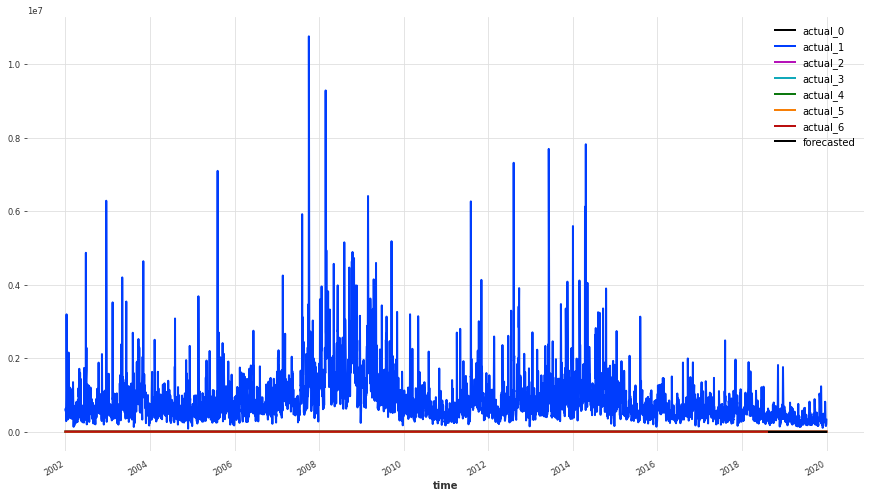

In [87]:
pred = model_cov.predict(
    n=500,
    series=y_train,
    past_covariates=covariates
)

combined_data_TS_filled.plot(label = "actual")
pred.plot(label = "forecasted")
plt.legend()